In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
import numpy as np
import pandas as pd
import awkward as ak
from numba import njit
import vector
vector.register_numba()
vector.register_awkward()
import torch

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist
import plot_loss
from torch import optim
from tqdm.notebook import trange

from sklearn.preprocessing import StandardScaler

In [3]:
#df = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")
df = ak.from_parquet("all_jets_v6.parquet")

In [4]:
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met
) = ak.unzip(df)

jets = ak.with_name(jets, name="Momentum4D")
partons_matched = ak.with_name(partons_matched, name="Momentum4D")
partons = ak.with_name(partons, name="Momentum4D")
lepton_partons = ak.with_name(lepton_partons, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")

In [5]:
@njit
def sum_vectors_all(arrays):
    size = len(arrays)
    results = np.zeros((size, 4))
    for i, array in enumerate(arrays):
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for v in array:
            total = total + v
        results[i, 0] = total.px
        results[i, 1] = total.py
        results[i, 2] = total.pz
        results[i, 3] = total.E
    return results


def get_vector_sum(vectors):
    out = sum_vectors_all(vectors)
    return vector.awk({
        "px": out[:, 0],
        "py": out[:, 1],
        "pz": out[:, 2],
        "E": out[:, 3],
    })

In [107]:
thad = get_vector_sum(partons[(partons.prov==2)|(partons.prov==5)])
tlep = partons[(partons.prov==3)] + lepton_partons[:,0] + lepton_partons[:,1]
higgs = get_vector_sum(partons[(partons.prov==1)])
gluons = partons[partons.prov==4]

vecpad = ak.with_name(ak.Array({"pt":[0.],"eta": [0.],"phi": [0.], "mass": [0.]}), name="Momentum4D")[0]
G = ak.pad_none(gluons, 1, axis=1)
gluon = ak.fill_none(G, vecpad)[:,0]


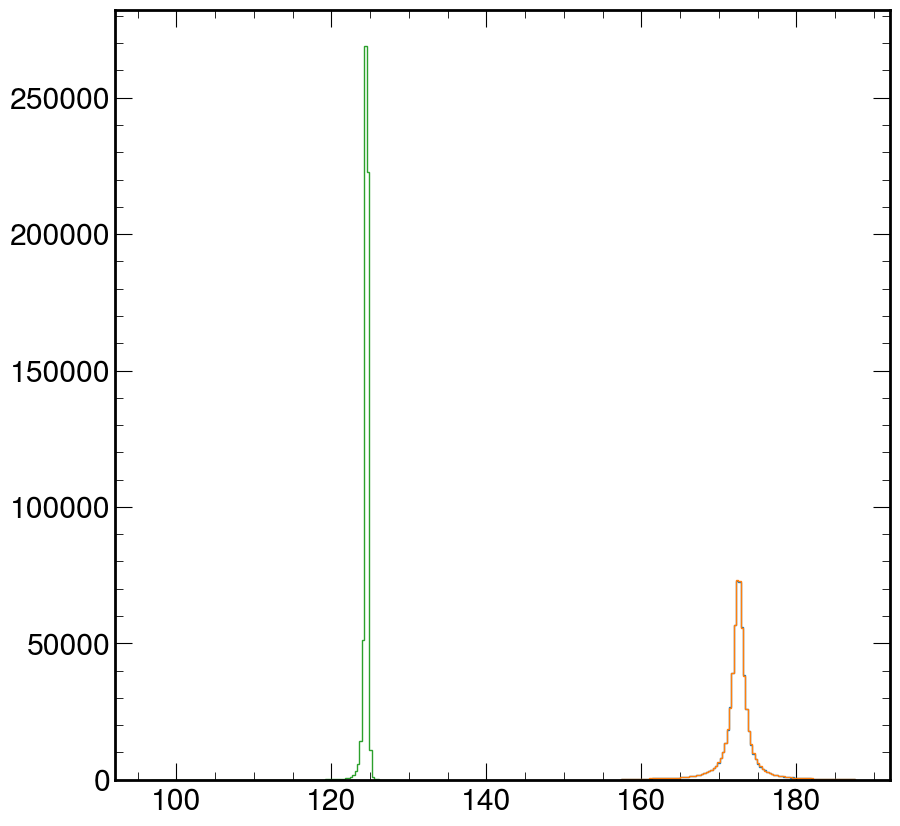

In [17]:
plt.hist(tlep.mass, bins=100, histtype="step", label="tlep mass")
plt.hist(thad.mass, bins=100, histtype="step", label="thad mass")
plt.hist(higgs.mass, bins=100, histtype="step", label="higgs mass");

In [18]:
ttH_syst = tlep+ thad + higgs

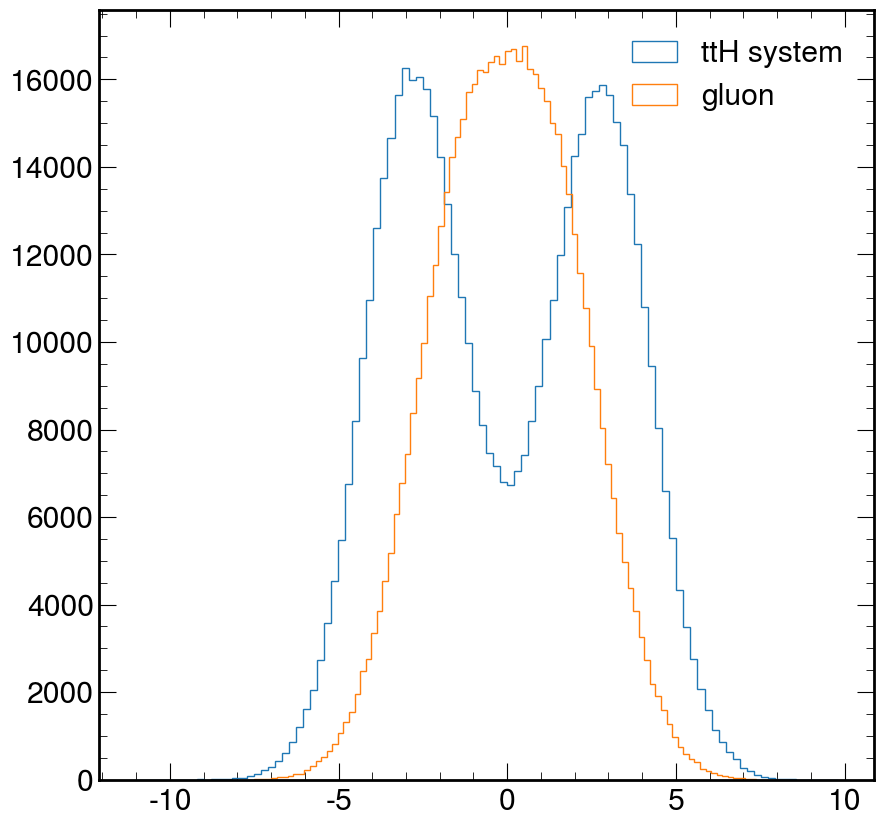

In [103]:
plt.hist(ttH_syst.eta, bins=100, histtype="step", label="ttH system");
plt.hist(gluon.eta, bins=100, histtype="step", label="gluon");
plt.legend()

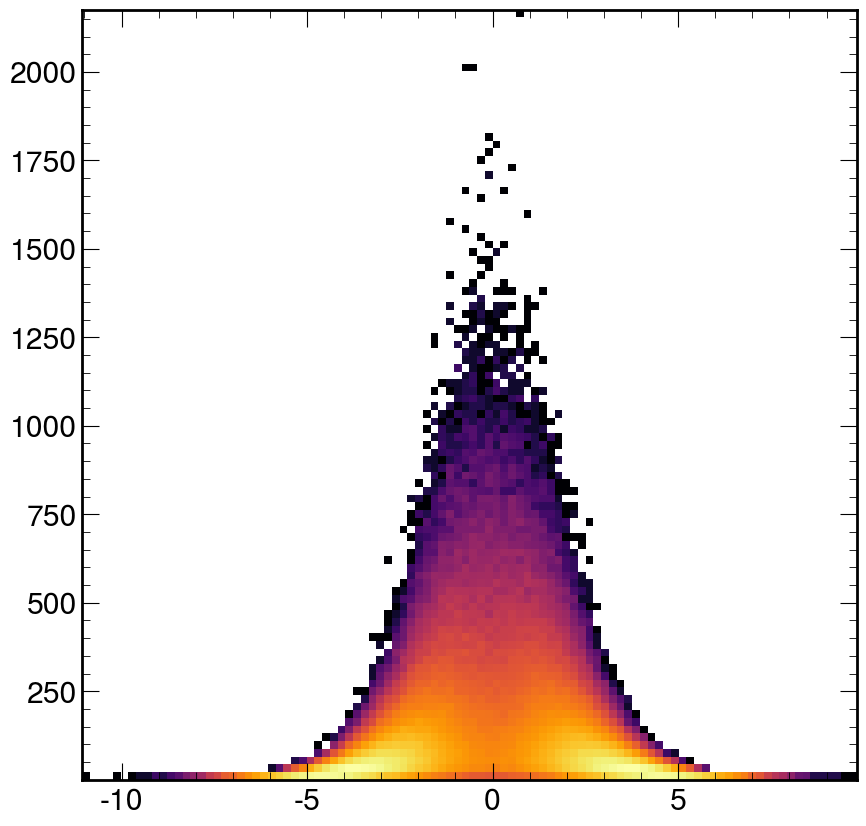

In [121]:
plt.hist2d(ak.to_numpy(ttH_syst[:,0].eta),
           ak.to_numpy(ttH_syst[:,0].pt), bins=100, cmap="inferno", cmin=1, norm=LogNorm());

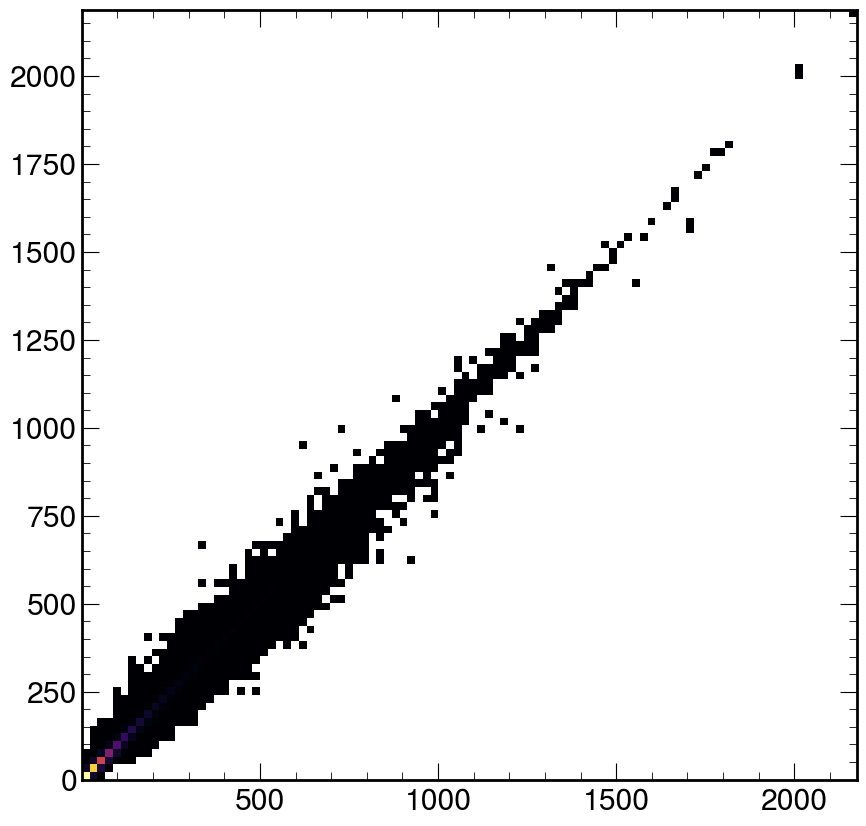

In [120]:
plt.hist2d(ak.to_numpy(ttH_syst[:,0].pt),
           ak.to_numpy(gluon.pt), bins=100, cmap="inferno", cmin=1);

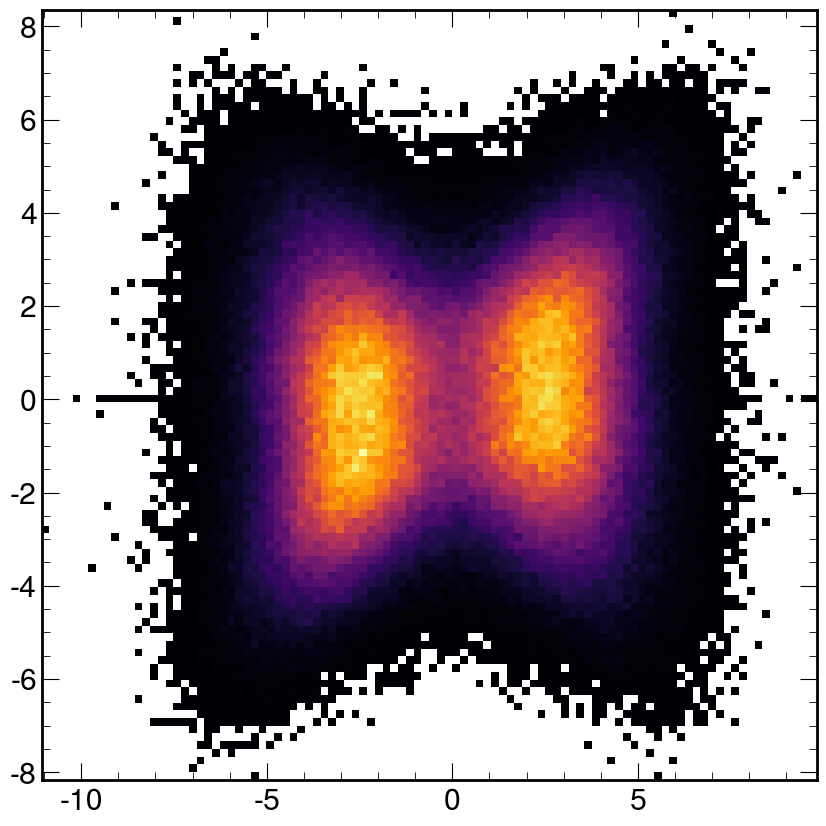

In [117]:
plt.hist2d(ak.to_numpy(ttH_syst[:,0].eta),
           ak.to_numpy(gluon.eta), bins=100, cmap="inferno", cmin=1);

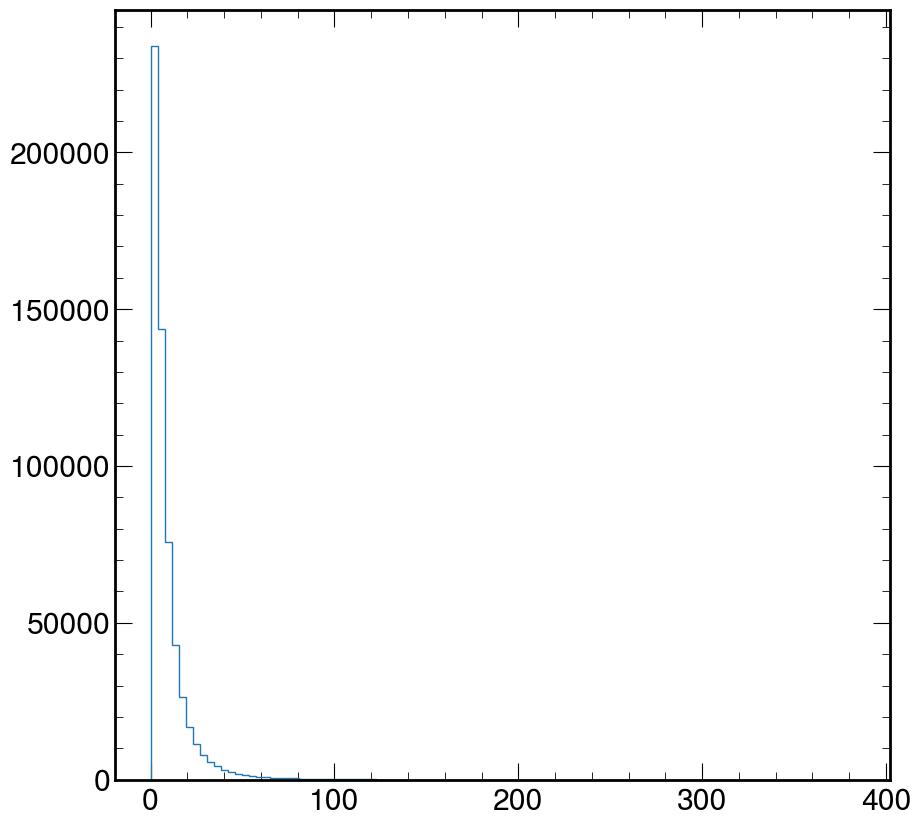

In [118]:
plt.hist((ttH_syst+gluon).pt, bins=100, histtype="step");